In [1]:
import dask_jobqueue
import socket
from dask_jobqueue import LSFCluster
import os

In [2]:
node_memory = 256
n_workers_per_node = 4
memory = '{}GB'.format(node_memory/n_workers_per_node)
notebook_name = "jag"

In [3]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), header_skip=['-n ','-R','-M', '-P', '-W'], 
                     job_extra = ['-nnodes 1', '-G asccasc', '-W 00:30', '-o {}.log'.format(notebook_name), '-e {}.log'.format(notebook_name)], use_stdin=True, scheduler_options={'host': socket.gethostname()})

In [4]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import time
from time import sleep

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:8787/status,
Dashboard: http://192.168.66.200:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:33373,Workers: 0
Dashboard: http://192.168.66.200:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
n_workers = 32

In [7]:
cluster.scale(n_workers)

In [8]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val< n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 28 of 32
32 workers started


In [9]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [10]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [11]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-cosmoflow-32-epoch-2"

In [12]:
num_ranks = 128

In [13]:
pbar = ProgressBar()
pbar.register()

### process dataset per rank

In [14]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [15]:
ddf.npartitions

504

In [16]:
#client.cancel(ddf)

In [17]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [18]:
#ddf[0].head()

In [19]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

In [20]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [21]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [22]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [23]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [24]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [25]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [26]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [27]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [28]:
io_ddf = io_ddf.persist()

In [29]:
wait(io_ddf)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 464)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 154)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 381)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 46)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 91)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 132)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 251)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259bf05da6', 473)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-a84baaa68f10f6f3bdb6a1259b

In [30]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [31]:
len(all_filenames)

644773

In [32]:
relevant_filenames = all_filenames.to_numpy()

In [33]:
file_df = io_ddf[io_ddf['filename'].isin(relevant_filenames)][['rank','filename', 'func_id','size', 'tstart', 'tend']].compute()

In [34]:
correct_dur = ((file_df['tend'] - file_df['tstart']) > 0)
file_df['bandwidth'] = -100
file_df['bandwidth'] = file_df['bandwidth'].mask(correct_dur, file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0)

In [35]:
file_df

,rank,filename,func_id,size,tstart,tend,bandwidth
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,open64,0,18.678453,18.679020,0.000000
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.814419,18.817913,2.235808
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,35.612858,35.612926,113.777778
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,50.504070,50.504166,81.920000
21346,0,/p/gpfs1/haridev/software/lbann/applications/p...,close,0,50.504601,50.504627,0.000000
...,...,...,...,...,...,...,...
7991540,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.874512,6446.875000,4096.000000
7991542,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.875000,6446.875488,4096.000000
7991546,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,6446.875488,6446.875488,-100.000000
7991549,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,16,6446.875488,6446.875488,-100.000000


In [36]:
file_df[file_df['func_id'].str.contains('read')]

,rank,filename,func_id,size,tstart,tend,bandwidth
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.814419,18.817913,2.235808
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,35.612858,35.612926,113.777778
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,50.504070,50.504166,81.920000
24291,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,8,1001.773621,1001.793457,0.000385
24292,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,16,1001.793457,1001.793518,0.250000
...,...,...,...,...,...,...,...
7991538,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.874512,6446.874512,-100.000000
7991540,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.874512,6446.875000,4096.000000
7991542,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.875000,6446.875488,4096.000000
7991546,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,6446.875488,6446.875488,-100.000000


In [41]:
file_df[file_df['func_id'].str.contains('read') & (file_df['bandwidth'] == -100)]

,rank,filename,func_id,size,tstart,tend,bandwidth
24299,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,512,1001.794922,1001.794922,-100.0
24300,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,544,1001.794922,1001.794922,-100.0
24301,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,328,1001.794983,1001.794983,-100.0
24322,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,512,1117.275146,1117.275146,-100.0
24328,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,544,1117.275879,1117.275879,-100.0
...,...,...,...,...,...,...,...
7991527,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,328,6446.788086,6446.788086,-100.0
7991529,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,6446.788086,6446.788086,-100.0
7991538,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,6446.874512,6446.874512,-100.0
7991546,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,6446.875488,6446.875488,-100.0


/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/cosmoflow/20210920_125715_lbann_cosmoflow/experiment.prototext


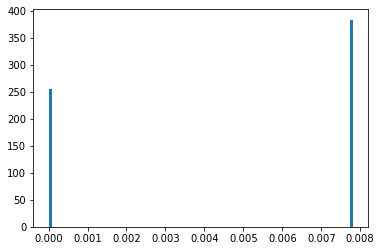

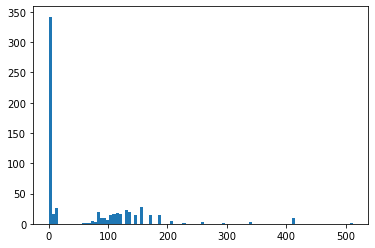

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_0_float.hdf5


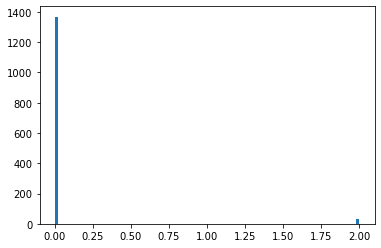

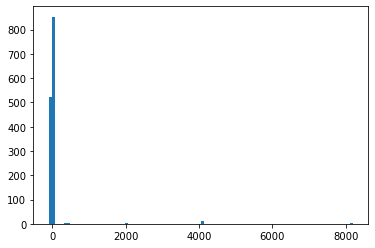

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6981523_0_0_0_float.hdf5


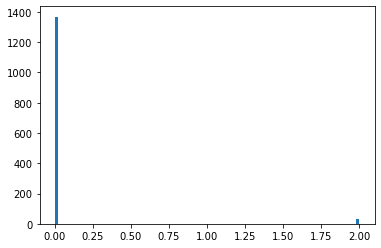

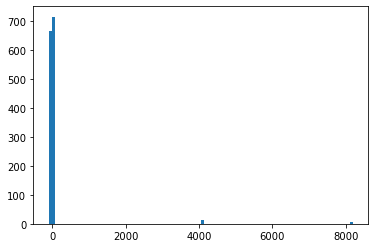

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a8515541_0_0_0_float.hdf5


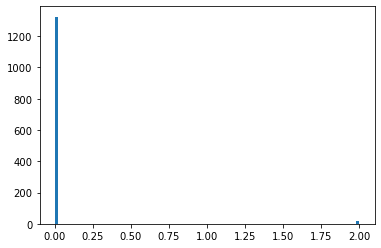

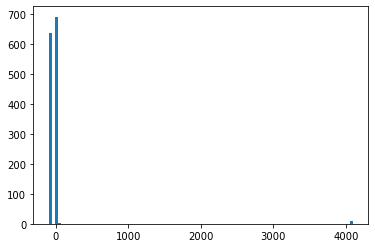

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13383679_3_2_0_float.hdf5


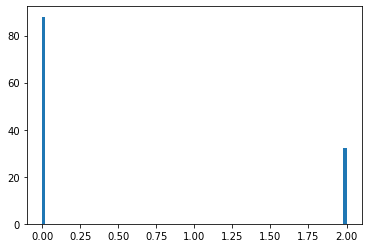

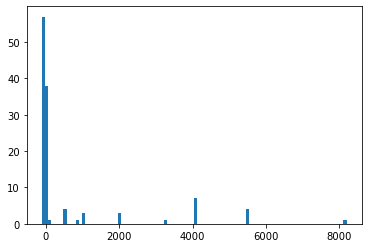

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6312225_3_1_0_float.hdf5


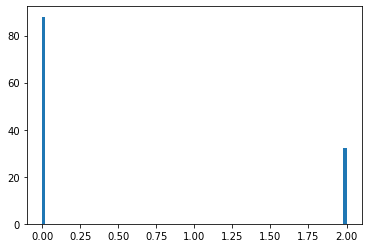

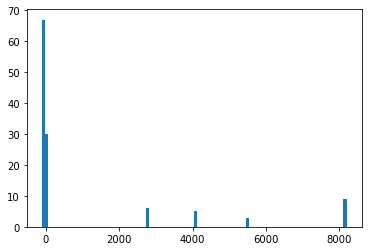

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a444662_2_1_1_float.hdf5


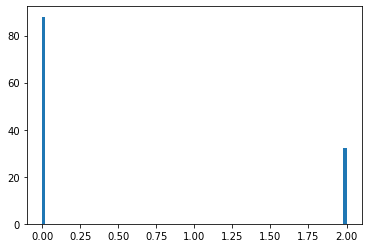

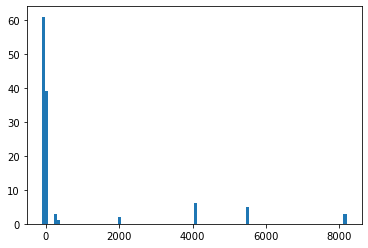

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11327158_2_3_1_float.hdf5


KeyboardInterrupt: 

In [39]:
for filename in relevant_filenames:
    print(filename)
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'], bins=100)
    plt.show()